In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn import preprocessing
import numpy as np

In [29]:
# Read the files with the pandas dataFrame
#  pass use the '\t' delimiter as argument because it is a tab separated file to prevent parser error

df_train = pd.read_csv('drugsCom_raw/drugsComTest_raw.tsv', delimiter='\t')
df_test = pd.read_csv('drugsCom_raw/drugsComTrain_raw.tsv', delimiter='\t')

In [30]:
print(df_train.shape)
print(df_test.shape)

(53766, 7)
(161297, 7)


In [31]:
# combine the two dataFrames into one for a bigger data size and ease of preprocessing
df_all = pd.concat([df_train,df_test])

In [32]:
print(df_all.shape)

(215063, 7)


In [33]:
# rename columns
df_all.columns = ['Id','drugName','condition','review','rating','date','usefulCount'] 

In [34]:
#convert date to datetime eventhough we are not using date in this
%time df_all['date'] = pd.to_datetime(df_all['date'])   

CPU times: user 39.9 s, sys: 685 ms, total: 40.6 s
Wall time: 55.4 s


In [35]:
df_all['month'] = df_all['date'].dt.month

In [36]:
df_all['year'] = df_all['date'].dt.year

In [131]:
df_all['day'] = df_all['date'].dt.day

In [132]:
df_all.head()

,Id,drugName,condition,review,rating,date,usefulCount,month,year,review_clean,condition_label,day
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,2012-02-28,22,2,2012,tri antidepress year citalopram fluoxetin amit...,273,28
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,2009-05-17,17,5,2009,son crohn diseas done well asacol no complaint...,253,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,2017-09-29,3,9,2017,quick reduct symptom,847,29
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,2017-03-05,35,3,2017,contrav combin drug use alcohol smoke opioid c...,869,5
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,2015-10-22,4,10,2015,birth control one cycl read review type simila...,175,22


### Data Preprocessing - Condition

Text(0.5, 1.0, 'Total Missing Value ')

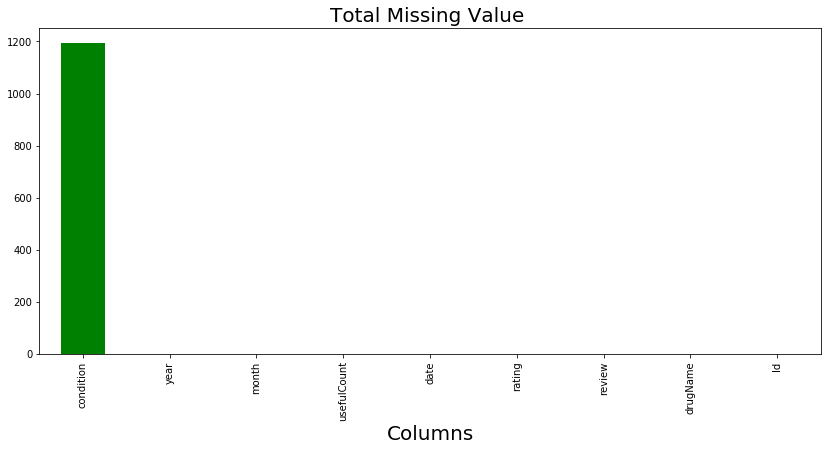

In [38]:
percent = (df_all.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (14,6), fontsize = 10, color='green')
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value ", fontsize = 20)

In [39]:
df_all = df_all.dropna(axis=0)

Text(0.5, 1.0, 'Total Missing Value ')

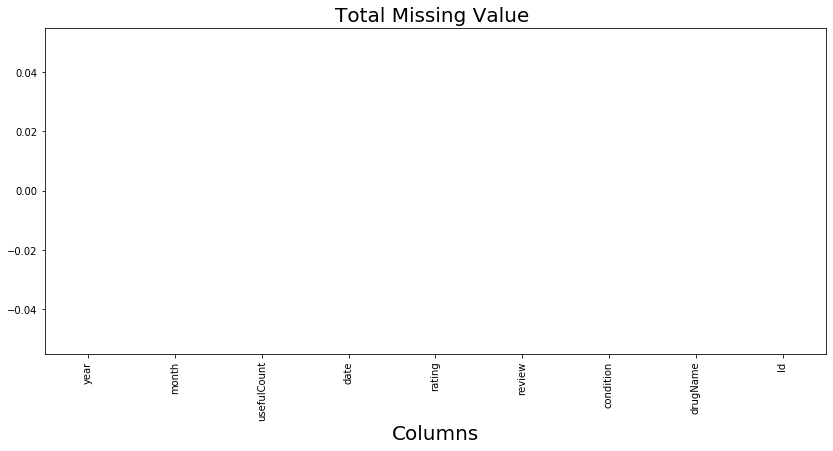

In [40]:
percent = (df_all.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (14,6), fontsize = 10, color='green')
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value ", fontsize = 20)

In [41]:
df_all.shape

(213869, 9)

### Data Preprocessing - Review Text, NLTK

In [42]:
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
#import lightgbm as lgb

#pd.options.mode.chained_assignment = None
#pd.options.display.max_columns = 999
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn import metrics

In [43]:
nltk.download(['punkt','stopwords'])

[nltk_data] Downloading package punkt to /Users/james/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/james/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [44]:
stops = set(stopwords.words('english'))

In [45]:
not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [46]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stops]
    # 6. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(stemming_words))

In [47]:
df_all['review_clean'] = df_all['review'].apply(review_to_words)

In [48]:
df_all.head(10)

,Id,drugName,condition,review,rating,date,usefulCount,month,year,review_clean
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,2012-02-28,22,2,2012,tri antidepress year citalopram fluoxetin amit...
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,2009-05-17,17,5,2009,son crohn diseas done well asacol no complaint...
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,2017-09-29,3,9,2017,quick reduct symptom
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,2017-03-05,35,3,2017,contrav combin drug use alcohol smoke opioid c...
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,2015-10-22,4,10,2015,birth control one cycl read review type simila...
5,208087,Zyclara,Keratosis,"""4 days in on first 2 weeks. Using on arms an...",4.0,2014-07-03,13,7,2014,day first week use arm face put vaselin lip ey...
6,215892,Copper,Birth Control,"""I&#039;ve had the copper coil for about 3 mon...",6.0,2016-06-06,1,6,2016,copper coil month realli excit thought not tak...
7,169852,Amitriptyline,Migraine Prevention,"""This has been great for me. I&#039;ve been on...",9.0,2009-04-21,32,4,2009,great week last week headach went away tylenol...
8,23295,Methadone,Opiate Withdrawal,"""Ive been on Methadone for over ten years and ...",7.0,2016-10-18,21,10,2016,ive methadon ten year current tri get drug ive...
9,71428,Levora,Birth Control,"""I was on this pill for almost two years. It d...",2.0,2011-04-16,3,4,2011,pill almost two year work far not get pregnant...


In [50]:
df_all.shape

(213869, 10)

In [51]:
df_all = df_all.dropna(axis=0)

In [52]:
df_all.shape

(213869, 10)

In [53]:
df_all.isnull().sum()

Id              0
drugName        0
condition       0
review          0
rating          0
date            0
usefulCount     0
month           0
year            0
review_clean    0
dtype: int64

In [55]:
df_all.head(10)

,Id,drugName,condition,review,rating,date,usefulCount,month,year,review_clean
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,2012-02-28,22,2,2012,tri antidepress year citalopram fluoxetin amit...
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,2009-05-17,17,5,2009,son crohn diseas done well asacol no complaint...
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,2017-09-29,3,9,2017,quick reduct symptom
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,2017-03-05,35,3,2017,contrav combin drug use alcohol smoke opioid c...
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,2015-10-22,4,10,2015,birth control one cycl read review type simila...
5,208087,Zyclara,Keratosis,"""4 days in on first 2 weeks. Using on arms an...",4.0,2014-07-03,13,7,2014,day first week use arm face put vaselin lip ey...
6,215892,Copper,Birth Control,"""I&#039;ve had the copper coil for about 3 mon...",6.0,2016-06-06,1,6,2016,copper coil month realli excit thought not tak...
7,169852,Amitriptyline,Migraine Prevention,"""This has been great for me. I&#039;ve been on...",9.0,2009-04-21,32,4,2009,great week last week headach went away tylenol...
8,23295,Methadone,Opiate Withdrawal,"""Ive been on Methadone for over ten years and ...",7.0,2016-10-18,21,10,2016,ive methadon ten year current tri get drug ive...
9,71428,Levora,Birth Control,"""I was on this pill for almost two years. It d...",2.0,2011-04-16,3,4,2011,pill almost two year work far not get pregnant...


### Add condition Label

In [73]:
le = preprocessing.LabelEncoder()
df_condition_label = df_all[["condition"]].apply(le.fit_transform)
df_condition_label.columns = ['condition_label']

In [68]:
df_all = pd.concat([df_all, df_condition_label], axis=1)

In [69]:
df_all.head(10)

,Id,drugName,condition,review,rating,date,usefulCount,month,year,review_clean,condition_label
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,2012-02-28,22,2,2012,tri antidepress year citalopram fluoxetin amit...,273
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,2009-05-17,17,5,2009,son crohn diseas done well asacol no complaint...,253
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,2017-09-29,3,9,2017,quick reduct symptom,847
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,2017-03-05,35,3,2017,contrav combin drug use alcohol smoke opioid c...,869
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,2015-10-22,4,10,2015,birth control one cycl read review type simila...,175
5,208087,Zyclara,Keratosis,"""4 days in on first 2 weeks. Using on arms an...",4.0,2014-07-03,13,7,2014,day first week use arm face put vaselin lip ey...,473
6,215892,Copper,Birth Control,"""I&#039;ve had the copper coil for about 3 mon...",6.0,2016-06-06,1,6,2016,copper coil month realli excit thought not tak...,175
7,169852,Amitriptyline,Migraine Prevention,"""This has been great for me. I&#039;ve been on...",9.0,2009-04-21,32,4,2009,great week last week headach went away tylenol...,522
8,23295,Methadone,Opiate Withdrawal,"""Ive been on Methadone for over ten years and ...",7.0,2016-10-18,21,10,2016,ive methadon ten year current tri get drug ive...,594
9,71428,Levora,Birth Control,"""I was on this pill for almost two years. It d...",2.0,2011-04-16,3,4,2011,pill almost two year work far not get pregnant...,175


In [71]:
df_all["condition_label"].max()

915

In [72]:
df_all["condition_label"].min()

0

### UsefulCount

In [94]:
df_all["usefulCount"].describe()

count    213869.000000
mean         28.094118
std          36.401377
min           0.000000
25%           6.000000
50%          16.000000
75%          36.000000
max        1291.000000
Name: usefulCount, dtype: float64

In [95]:
maxUsefulCount = df_all["usefulCount"].max()
normUsefulCount2 = [x/maxUsefulCount for x in df_all["usefulCount"].to_list()]

In [106]:
maxUsefulCount

1291

In [96]:
pd.DataFrame(normUsefulCount2).describe()

,0
count,213869.000000
mean,0.021762
std,0.028196
min,0.000000
25%,0.004648
50%,0.012393
75%,0.027885
max,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129caf690>]],
      dtype=object)

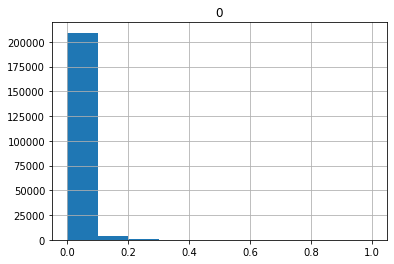

In [105]:
pd.DataFrame(normUsefulCount2).hist()

In [110]:
np.array([df_all["usefulCount"].to_numpy()]).shape

(1, 213869)

In [111]:
np.array([df_all["usefulCount"].to_numpy()]).T.shape

(213869, 1)

In [114]:
normUsefulCount3 = preprocessing.robust_scale(np.array([df_all["usefulCount"].to_numpy()]).T)

In [116]:
pd.DataFrame(normUsefulCount3).describe()

,0
count,213869.000000
mean,0.403137
std,1.213379
min,-0.533333
25%,-0.333333
50%,0.000000
75%,0.666667
max,42.500000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12edb5fd0>]],
      dtype=object)

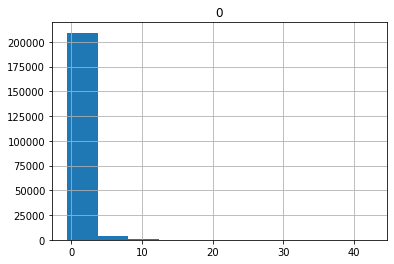

In [115]:
pd.DataFrame(normUsefulCount3).hist()

In [124]:
normUsefulCount4 = preprocessing.minmax_scale(np.array([df_all["usefulCount"].to_numpy()]).T)

In [125]:
normUsefulCount4.shape

(213869, 1)

In [126]:
pd.DataFrame(normUsefulCount4).describe()

,0
count,213869.000000
mean,0.021762
std,0.028196
min,0.000000
25%,0.004648
50%,0.012393
75%,0.027885
max,1.000000


In [97]:
normUsefulCount = normalize(np.array([df_all["usefulCount"].to_numpy()]).T)

In [98]:
normUsefulCount.shape

(213869, 1)

In [99]:
pd.DataFrame({'normalized_usefulCount': normUsefulCount[:, 0]}).describe()

,normalized_usefulCount
count,213869.000000
mean,0.961350
std,0.192759
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12ae06110>]],
      dtype=object)

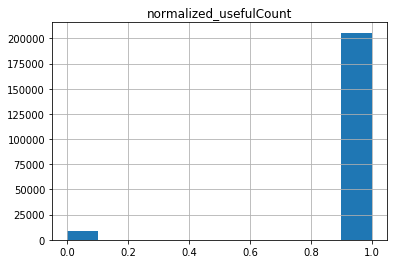

In [100]:
pd.DataFrame({'normalized_usefulCount': normUsefulCount[:, 0]}).hist()

### Save as CSV

In [133]:
df_all.to_csv('df_all_processed.csv')

### Sentiment Analysis

In [1]:
sid = SentimentIntensityAnalyzer()

NameError: name 'SentimentIntensityAnalyzer' is not defined